# Analysis of *The Lord of the Rings* Using Count-Based Word Vectors
## Author: Wesley Ho

Adapted from [Stanford CS244N, 2019](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/assignments/a1_preview/exploring_word_vectors.html).

In [63]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# All the dependencies you need, can be installed by running .
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
#nltk.download('reuters')
#from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import ast
import io

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *word2vec*. 

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

## Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | START | all | that | glitters | is   | not  | gold  | well | ends | END |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| START    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| END      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add START and END tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine START and END tokens encapsulating each document, e.g., "START All that glitters is not gold END", and include these tokens in our co-occurrence counts.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds START and END tokens to each of the documents, and lowercases words. You do **not** have perform any other kind of pre-processing.

In [13]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

def read_corpus_path(path):
    corpus = ""
    with io.open(path,'r',encoding='utf8') as f:
        corpus = f.read()
    return ast.literal_eval(corpus)

Let's have a look what these documents are like….

In [14]:
corpus = read_corpus_path("./lotr_complete.txt")
pprint.pprint(corpus[:1], compact=True, width=100)

[['<START>', 'This', 'book', 'is', 'largely', 'concerned', 'with', 'Hobbits', ',', 'and', 'from',
  'its', 'pages', 'a', 'reader', 'may', 'discover', 'much', 'of', 'their', 'character', 'and', 'a',
  'little', 'of', 'their', 'history', '.', 'Further', 'information', 'will', 'also', 'be', 'found',
  'in', 'the', 'selection', 'from', 'the', 'Red', 'Book', 'of', 'Westmarch', 'that', 'has',
  'already', 'been', 'published', ',', 'under', 'the', 'title', 'of', 'The', 'Hobbit', '.', 'That',
  'story', 'was', 'derived', 'from', 'the', 'earlier', 'chapters', 'of', 'the', 'Red', 'Book', ',',
  'composed', 'by', 'Bilbo', 'himself', ',', 'the', 'first', 'Hobbit', 'to', 'become', 'famous',
  'in', 'the', 'world', 'at', 'large', ',', 'and', 'called', 'by', 'him', 'There', 'and', 'Back',
  'Again', ',', 'since', 'they', 'told', 'of', 'his', 'journey', 'into', 'the', 'East', 'and',
  'his', 'return', ':', 'an', 'adventure', 'which', 'later', 'involved', 'all', 'the', 'Hobbits',
  'in', 'the', 'great'

### Implementing `distinct_words`

A method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html). You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [4]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.

    # Flattens corpus into a list of words
    corpus_words = [word for sample in corpus for word in sample]

    # Removes duplicates from list by casting to a set then back to a list
    corpus_words = list(set(corpus_words))

    corpus_words.sort()
    num_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, num_corpus_words


**Exercise:** Print hundred words of the sorted reuters corpus as well as the number of distinct words.

### Testing `distinct_words`

In [5]:
# ---------------------
# Run this sanity check
# ---------------------

# Define toy corpus
test_corpus = ["<START> All that glitters isn't gold <END>".split(" "), "<START> All's well that ends well <END>".split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted(list(set(["<START>", "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", "<END>"])))
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


---

### Implementing `compute_co_occurrence_matrix`

Writing a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


In [115]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "START All that glitters is not gold END" with window size of 4,
              "All" will co-occur with "START", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}
    
    # ------------------
    # Write your implementation here.

    # Create a dictionary that maps words to indices
    word2Ind = {word:ind for ind,word in enumerate(words)}

    # Initializes a square array of zeros where the 
    # side length is the number of words
    M = np.zeros((num_words,num_words))

    # Nested for loops to populate the co-occurence matrix
    for sample in corpus:
        # initializes windows to start of sample
        prev_window = [] # previous window empty at the start
        next_window = [word2Ind[x] for x in sample[1:max(1, min(len(sample) - 1,window_size+1))]]
        end_reached = False # used to keep track of if the next window needs to keep adding

        for index, word in enumerate(sample):
            # Calculates the index of the current word
            ind = word2Ind[word]

            # Iterates through both windows and adds to the co-occurance
            # matrix for every pair with the current word
            for prev_word in prev_window:
                M[ind][prev_word] += 1
            for next_word in next_window:
                M[ind][next_word] += 1
            
            # Appends current word to the previous window then removes the oldest word if necessary
            prev_window.append(ind)
            if len(prev_window) > window_size:
                prev_window.pop(0)
                
            # Adds to the next window if the end hasn't been reached
            if not end_reached:
                end = sample[max(1, min(index + window_size + 1,len(sample) - 1))]
                next_window.append(word2Ind[end])

                # If the end is reached, update the flag
                end_reached = end == END_TOKEN
            
            # Try to pop from the next window.
            # Since pop() throws an exception if index
            # doesn't exist, the try except block is necessary
            try:
                next_window.pop(0)
            except:
                pass

    # ------------------

    return M, word2Ind

**Exercise:** Print the first 10 rows and columns of the co-occurrence matrix of the corpus. 

In [116]:
matrix, word_to_index = compute_co_occurrence_matrix(corpus)

In [117]:
first_10_rows = [ matrix[i] for i in range(10) ]
first_10_cols = [ [ row[i] for row in matrix ] for i in range(10) ]

# Only print out the first 10 entries
# of each row and column since these
# are quite large

print("First 10 rows:")
for row in first_10_rows:
    print(row[0:10])

print()
print("First 10 columns:")
for col in first_10_cols:
    print(col[0:10])

First 10 rows:
[6.520e+02 1.389e+03 1.900e+01 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 1.300e+01 4.000e+00 1.000e+00]
[1.389e+03 3.600e+02 2.600e+01 0.000e+00 1.000e+00 2.000e+00 0.000e+00
 7.000e+00 1.000e+00 1.000e+00]
[19. 26. 14.  0.  0.  0.  0.  0.  0.  0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[13.  7.  0.  0.  0.  0.  0.  0.  0.  0.]
[4. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

First 10 columns:
[652.0, 1389.0, 19.0, 0.0, 0.0, 1.0, 0.0, 13.0, 4.0, 1.0]
[1389.0, 360.0, 26.0, 0.0, 1.0, 2.0, 0.0, 7.0, 1.0, 1.0]
[19.0, 26.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[13.0, 7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[4.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.

**Exercise:** Find words that co-occur with each other. 
- What is the largest co_occurrence you can find?
- Which words co-occur with "energy"?
- What is the largest co_occurrence between two nouns you can find?
- Is co_occurrence symmetric?
- Do words co_occur with themselves?
- What happens if a word is not in the dictionary?

In [118]:
# Largest co-occurrence?
max_value = matrix.max()
max_row, max_col = np.unravel_index(matrix.argmax(), matrix.shape)

# Invert word_to_index to create a lookup table by index
index_to_word = { v: k for k, v in word_to_index.items() }
first_word = index_to_word[max_row]
second_word = index_to_word[max_col]

print("Words with largest co-occurrence: '" + first_word + "' and '" + second_word + "'")

Words with largest co-occurrence: ',' and 'and'


In [119]:
# Which words co-occur with a specific word?
word = "Ring"
word_index = word_to_index[word]

print("Word index of", word, "=", word_index)
max_value = matrix[word_index].max()
other_index = matrix[word_index].argmax()
other_word = index_to_word[other_index]
print("Most co-occurring word with '" + word + "' is '" + other_word + "' (" + str(other_index) + ")")

Word index of Ring = 2696
Most co-occurring word with 'Ring' is 'the' (14697)


In [ ]:
# Largest co-occurrence between two nouns
# https://stackoverflow.com/questions/42098093/get-indices-of-top-n-values-in-2d-numpy-ndarray-or-numpy-matrix

In [120]:
# Is co-occurrence symmetric?

symmetric = True

# Iterate through all possible pairs
for i in range(len(matrix)):
    for j in range(i):
        if matrix[i][j] != matrix[j][i]:
            print(i, j)
            symmetric = False
print("Symmetric:", symmetric)

614 613
Symmetric: False


In [122]:
print(index_to_word[614], index_to_word[613])

<START> <END>


In [123]:
# Do words co-occur?
index = 2696  # 'Ring'
print(matrix[index][index])

6.0


In [124]:
# What happens if a word is not in the dictionary?

# Uh...an index error

### Testing `compute_co_occurrence_matrix`

In [8]:
# ---------------------
# Run this sanity check
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["<START> All that glitters isn't gold <END>".split(" "), "<START> All's well that ends well <END>".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2Ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.]]
)
word2Ind_ans = {'<END>': 0, '<START>': 1, 'All': 2, "All's": 3, 'ends': 4, 'glitters': 5, 'gold': 6, "isn't": 7, 'that': 8, 'well': 9}
# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


## Dimensionality Reduction


The rows (or columns) of the co-occurrence matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. 

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

**Note:** If you want to explore the background, here is an [introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168. See also [Matrix decompositions and latent semantic indexing](https://nlp.stanford.edu/IR-book/pdf/18lsi.pdf). These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as *[Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD)* — then there are reasonably scalable techniques to compute those iteratively.

### Implementing `reduce_to_k_dim`

A method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. **Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [125]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.

    # Creates a new TruncatedSVD model with specified hyperparameters (See link above for details)
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    # Fits the model parameters to the co-occurance matrix
    svd.fit(M)
    # Uses the fit model to calculate a reduced matrix
    M_reduced = svd.transform(M)
    # ------------------

    print("Done.")
    return M_reduced

### Testing `compute_co_occurrence_matrix` and `reduce_to_k_dim`

In [126]:
# ---------------------
# Run this sanity check
# ---------------------

# Define toy corpus and run student code
test_corpus = ["<START> All that glitters isn't gold <END>".split(" "), "<START> All's well that ends well <END>".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


**Exercise:** This continues the exercise about the co-occurrence matrix. Compute the similarity of various pairs of words.

### Implementing `plot_embeddings`

A function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`). For this example, you may find it useful to adapt [this code](https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [127]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    
    # Initializes empty plot
    fig, ax = plt.subplots() 
    
    # Calculates incices of words to print
    indices = [word2Ind[word] for word in words] 
    
    # The __getitem__ function is the internal function called
    # when something is indexed using []. Therefore, the map
    # is essentially calling __getitem__ for every index in
    # indices. When cast to a list, the mapped function is called
    # and the result is a subset of the original lists with just the
    # indices we need. For more info see this link:
    # https://www.geeksforgeeks.org/__getitem__-in-python/
    X_map = map(M_reduced[:,0].__getitem__, indices)
    Y_map = map(M_reduced[:,1].__getitem__, indices)
    
    # X and Y are the embeddings for just the desired words
    X = list(X_map)
    Y = list(Y_map)
    
    # ax.scatter makes a scatter plot. X and Y must
    # have the same number of elements. color and marker
    # are defined by matplotlib. Here's a link to the documentation
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.scatter.html
    ax.scatter(X, Y, color='red', marker='x')

    # ax.annotate makes an annotation at the specified location
    # this for loop writes the word represented by the embedding
    # directly next to its point on the plot
    for index, word in enumerate(words):
        ax.annotate(word, (X[index], Y[index]))
    
    # this function displays the plot you've made
    plt.show()
    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


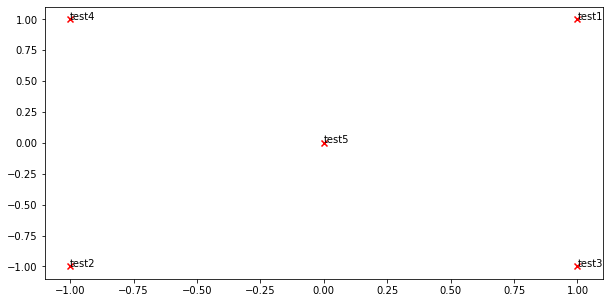

--------------------------------------------------------------------------------


In [128]:
# ---------------------
# Run this sanity check
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

## Co-Occurrence Plot Analysis

Now we will put together all the parts! We will compute the co-occurrence matrix with fixed window of 4, over the Reuters "crude" corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

In [134]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
corpus = read_corpus_path("./lotr_complete.txt")
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

Running Truncated SVD over 16561 words...
Done.


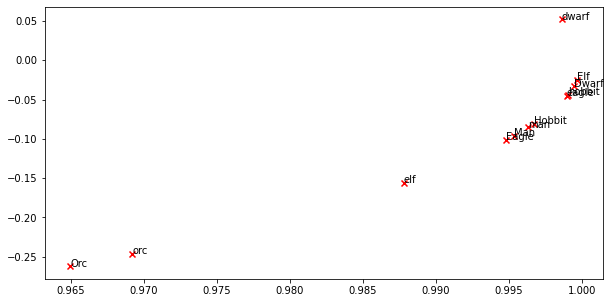

In [135]:
words = ['man', 'elf', 'hobbit', 'dwarf', 'orc', 'eagle', 'Man', 'Elf', 'Hobbit', 'Dwarf', 'Orc', 'Eagle']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

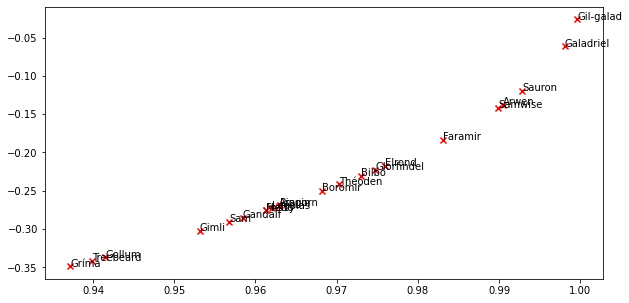

In [144]:
words = ['Aragorn', 'Legolas', 'Gimli', 'Frodo', 'Samwise',
         'Gandalf', 'Gollum', 'Merry', 'Pippin', 'Bilbo',
         'Boromir', 'Treebeard', 'Sam', 'Sauron', 'Elrond',
         'Arwen', 'Théoden', 'Gríma', 'Galadriel', 'Gil-galad',
         'Glorfindel', 'Faramir' ]
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

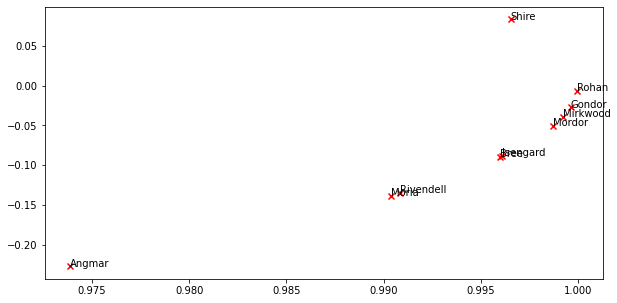

In [146]:
words = ['Shire', 'Mordor', 'Isengard', 'Moria', 'Gondor', 'Rohan', 'Mirkwood',
         'Rivendell', 'Bree', 'Angmar']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

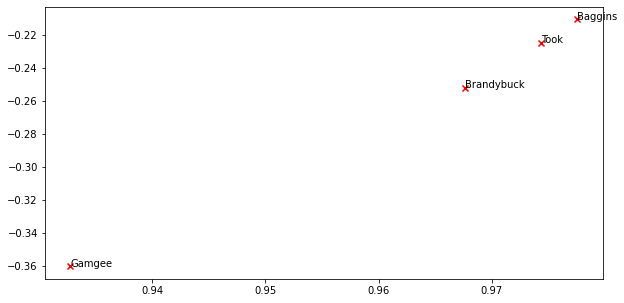

In [139]:
words = ['Baggins', 'Took', 'Brandybuck', 'Gamgee']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

**Exercise:** Make a list of words that forms two (or three) distinct clusters in the 2-dimensional plot. Hint: [Download the corpus](http://kdd.ics.uci.edu/databases/reuters21578/reuters21578.html) and have a look at the texts from which the words are taken. Post a screenshot of the plot together with an explanation
